In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# !pip uninstall torch
# !pip install torch
# !pip install  torchvision torchaudio cuda -d torch
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
import pickle
import numpy as np
import random
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [4]:
SEED = 2000
#Это нужно для воспроизводимости результатов
#------------------------------------------------------
#воспроизводимость работы RNG для разных устройств и библиотек
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
#будут использоваться детерминированные алгоритмы: на одинаковом входе будет одинаковый выход
torch.backends.cudnn.deterministic = True 
#------------------------------------------------------
#https://pytorch.org/docs/stable/notes/randomness.html

In [5]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [6]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        
        if self.mode == 'train': 
            transform = transforms.Compose([
                #здесь добавлена аугментация
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                #поворот картинки на угол с некоторым шансом
                transforms.RandomRotation(degrees=30), 
                #отражение по горизонтали
                transforms.RandomHorizontalFlip(),
                #отражение по вертикали
                transforms.RandomVerticalFlip(),
                #произвольно изменяет яркость, контраст, насыщенность и оттенок изображения
                transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2, contrast=0.2),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [8]:
#Этот код нужен, только если работать из Colab.
#Берет датасет в формате zip с гугл диска и распаковывает его в папку simpsons.
#Нужно загрузить датасет на диск, чтобы это работало. 
#------------------------------------------------------

# from google.colab import drive
# drive.mount('/content/gdrive/')

# !unzip -q /content/gdrive/My\ Drive/journey-springfield.zip -d simpsons

In [9]:
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset')

#Если работать из Colab, пути к данным будут другие, они представлены ниже (для моей версии).
#------------------------------------------------------
# TRAIN_DIR = Path('simpsons/train/simpsons_dataset')
# TEST_DIR = Path('simpsons/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))


In [10]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [11]:
val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [12]:
#балансировка классов: чтобы модель могла нормально обучаться на классах, для которых мало примеров
#https://discuss.pytorch.org/t/how-to-implement-oversampling-in-cifar-10/16964/14 -- источник, ссылка из исходного ноутбука с дз
from torch.utils.data import WeightedRandomSampler
targets = [train_dataset.label_encoder.transform([label]) for label in train_dataset.labels]
class_count = np.unique(targets, return_counts=True)[1]
print(class_count)
weight = 1. / class_count
samples_weight = weight[targets].flatten()
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

print()

[ 685   32  467   80 1006   74  895  739   35  352    6  343   20   20
   91 1684  373  904  233    2 1015   96  968   53  185  809   13 1089
 1090  269   24   54  895   49   34   67   77  658   30   41    6  136]



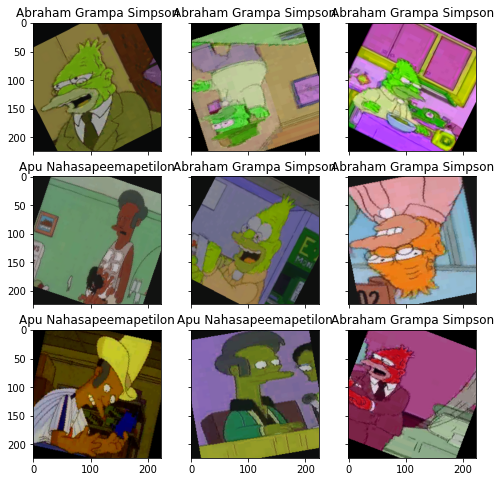

In [14]:
#смотрю на случайные тренировочные данные, также можно увидеть последствия аугментации
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [15]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [16]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [17]:
def train(train_dataset, val_dataset, model, epochs, batch_size, shuffle=True, sampler=None):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 3, 0.5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            pbar_outer.update(1)
            #сохранение весов модели на каждом шаге 
            weights = copy.deepcopy(densenet.state_dict())
            torch.save(weights, path_to+"/new_weights.pth")
            
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [18]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [19]:
from torchvision import models

In [20]:
#число классов
n_classes = len(np.unique(train_val_labels))
#размер батча для обучения
batch_size = 60

#может пригодиться для очистки памяти GPU
#torch.cuda.empty_cache()

In [39]:
#скачиваю предобученную модель из представленных в torchvision
densenet = models.densenet161(pretrained=True).cuda()
#добавляю в нее еще один слой
densenet.fc = nn.Sequential( nn.Linear(1000, n_classes, bias = True))

In [22]:
for child in densenet.children():
    for param in child.parameters():
        param.requires_grad = True

Запустим обучение сети.

In [23]:
import copy
#путь для сохранения весов модели
path_to = '/kaggle/working/'
#weights = copy.deepcopy(densenet.state_dict())
#torch.save(weights, path_to+"/new_weights.pth")
#------------------------------------------------------
#этот же путь для Colab
# path_to = '/content/gdrive/MyDrive/simpsons'

In [40]:
#обучение модели
epochs = 26 
history = train(train_dataset, val_dataset, model=densenet, epochs=epochs, sampler = sampler, shuffle = False, batch_size=batch_size)

epoch:   0%|          | 0/26 [00:00<?, ?it/s]

loss 1.477762380745982


epoch:   4%|▍         | 1/26 [05:55<2:28:02, 355.29s/it]


Epoch 001 train_loss: 1.4778     val_loss 1.5148 train_acc 0.6069 val_acc 0.5963
loss 0.881822823574531


epoch:   8%|▊         | 2/26 [11:15<2:13:41, 334.21s/it]


Epoch 002 train_loss: 0.8818     val_loss 1.1839 train_acc 0.7579 val_acc 0.6613
loss 0.6840715002266418


epoch:  12%|█▏        | 3/26 [16:32<2:05:08, 326.46s/it]


Epoch 003 train_loss: 0.6841     val_loss 0.9186 train_acc 0.8105 val_acc 0.7604
loss 0.3946957339226148


epoch:  15%|█▌        | 4/26 [21:49<1:58:23, 322.87s/it]


Epoch 004 train_loss: 0.3947     val_loss 0.7031 train_acc 0.8867 val_acc 0.8107
loss 0.3296297400519684


epoch:  19%|█▉        | 5/26 [27:07<1:52:25, 321.20s/it]


Epoch 005 train_loss: 0.3296     val_loss 0.6741 train_acc 0.9104 val_acc 0.8116
loss 0.30279934516717494


epoch:  23%|██▎       | 6/26 [32:27<1:46:50, 320.52s/it]


Epoch 006 train_loss: 0.3028     val_loss 0.6635 train_acc 0.9132 val_acc 0.8378
loss 0.2093365014015136


epoch:  27%|██▋       | 7/26 [37:43<1:41:06, 319.30s/it]


Epoch 007 train_loss: 0.2093     val_loss 0.5092 train_acc 0.9408 val_acc 0.8712
loss 0.1731082943437608


epoch:  31%|███       | 8/26 [43:01<1:35:34, 318.60s/it]


Epoch 008 train_loss: 0.1731     val_loss 0.5125 train_acc 0.9517 val_acc 0.8718
loss 0.15609379831142214


epoch:  35%|███▍      | 9/26 [48:18<1:30:09, 318.23s/it]


Epoch 009 train_loss: 0.1561     val_loss 0.4781 train_acc 0.9550 val_acc 0.8877
loss 0.12383543368069681


epoch:  38%|███▊      | 10/26 [53:34<1:24:41, 317.60s/it]


Epoch 010 train_loss: 0.1238     val_loss 0.4537 train_acc 0.9660 val_acc 0.8985
loss 0.10954575079325754


epoch:  42%|████▏     | 11/26 [58:50<1:19:17, 317.14s/it]


Epoch 011 train_loss: 0.1095     val_loss 0.4379 train_acc 0.9697 val_acc 0.8972
loss 0.09797548234967701


epoch:  46%|████▌     | 12/26 [1:04:21<1:14:58, 321.30s/it]


Epoch 012 train_loss: 0.0980     val_loss 0.4557 train_acc 0.9732 val_acc 0.8942
loss 0.08087416296247207


epoch:  50%|█████     | 13/26 [1:09:39<1:09:22, 320.20s/it]


Epoch 013 train_loss: 0.0809     val_loss 0.4211 train_acc 0.9776 val_acc 0.9060
loss 0.06980440305489924


epoch:  54%|█████▍    | 14/26 [1:14:56<1:03:51, 319.28s/it]


Epoch 014 train_loss: 0.0698     val_loss 0.4420 train_acc 0.9794 val_acc 0.9087
loss 0.07145913040456879


epoch:  58%|█████▊    | 15/26 [1:20:17<58:36, 319.68s/it]  


Epoch 015 train_loss: 0.0715     val_loss 0.4266 train_acc 0.9786 val_acc 0.9136
loss 0.0541947145206602


epoch:  62%|██████▏   | 16/26 [1:25:34<53:10, 319.04s/it]


Epoch 016 train_loss: 0.0542     val_loss 0.4450 train_acc 0.9843 val_acc 0.9119
loss 0.06021942219788772


epoch:  65%|██████▌   | 17/26 [1:30:53<47:51, 319.00s/it]


Epoch 017 train_loss: 0.0602     val_loss 0.4299 train_acc 0.9839 val_acc 0.9123
loss 0.05234052024595161


epoch:  69%|██████▉   | 18/26 [1:36:11<42:30, 318.76s/it]


Epoch 018 train_loss: 0.0523     val_loss 0.4369 train_acc 0.9851 val_acc 0.9188
loss 0.04702588232900978


epoch:  73%|███████▎  | 19/26 [1:41:32<37:15, 319.35s/it]


Epoch 019 train_loss: 0.0470     val_loss 0.4401 train_acc 0.9859 val_acc 0.9175
loss 0.04679844621074307


epoch:  77%|███████▋  | 20/26 [1:46:55<32:02, 320.46s/it]


Epoch 020 train_loss: 0.0468     val_loss 0.4304 train_acc 0.9868 val_acc 0.9171
loss 0.04685704320907448


epoch:  81%|████████  | 21/26 [1:52:26<26:58, 323.75s/it]


Epoch 021 train_loss: 0.0469     val_loss 0.4314 train_acc 0.9854 val_acc 0.9177
loss 0.048858850842280796


epoch:  85%|████████▍ | 22/26 [1:58:25<22:16, 334.20s/it]


Epoch 022 train_loss: 0.0489     val_loss 0.4301 train_acc 0.9856 val_acc 0.9205
loss 0.041938422712042046


epoch:  88%|████████▊ | 23/26 [2:04:37<17:16, 345.53s/it]


Epoch 023 train_loss: 0.0419     val_loss 0.4328 train_acc 0.9884 val_acc 0.9188
loss 0.03984816087012956


epoch:  92%|█████████▏| 24/26 [2:10:50<11:47, 353.69s/it]


Epoch 024 train_loss: 0.0398     val_loss 0.4376 train_acc 0.9882 val_acc 0.9190
loss 0.04632008143690159


epoch:  96%|█████████▌| 25/26 [2:16:57<05:57, 357.67s/it]


Epoch 025 train_loss: 0.0463     val_loss 0.4365 train_acc 0.9862 val_acc 0.9188
loss 0.0434646115997884


epoch: 100%|██████████| 26/26 [2:23:05<00:00, 330.23s/it]


Epoch 026 train_loss: 0.0435     val_loss 0.4347 train_acc 0.9869 val_acc 0.9190


In [25]:
# загрузка сохраненных весов модели
#densenet.load_state_dict(torch.load("../input/weig hts/new_weights.pth"))

Построим кривые обучения

In [41]:
loss, acc, val_loss, val_acc = zip(*history)

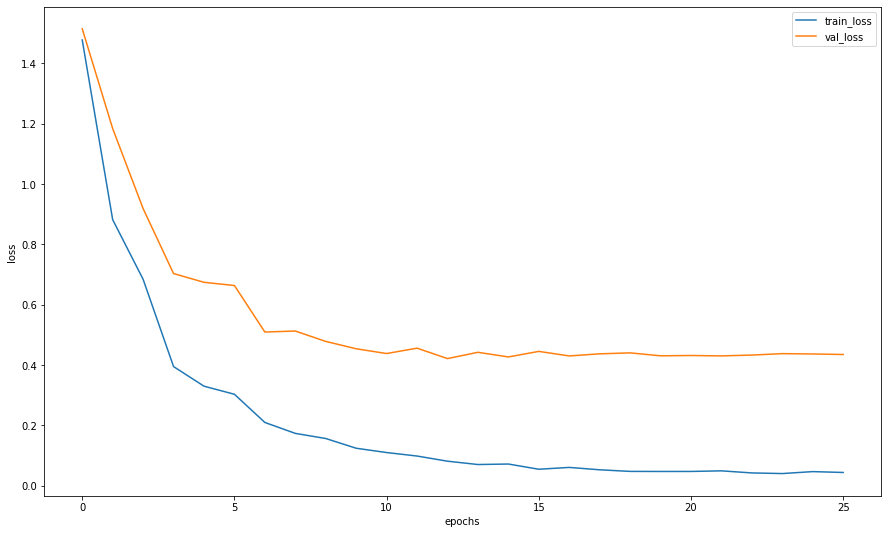

In [42]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [43]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

Далее код из исходного ноутбука с дз, где оцениваем f1-score на валидации.

In [44]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(densenet, ex_img.unsqueeze(0))

In [45]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(densenet, imgs)

In [46]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [47]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [48]:
from sklearn.metrics import f1_score
f1_score(actual_labels, y_pred, average='micro')

0.9500000000000001

Сделаем классную визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.


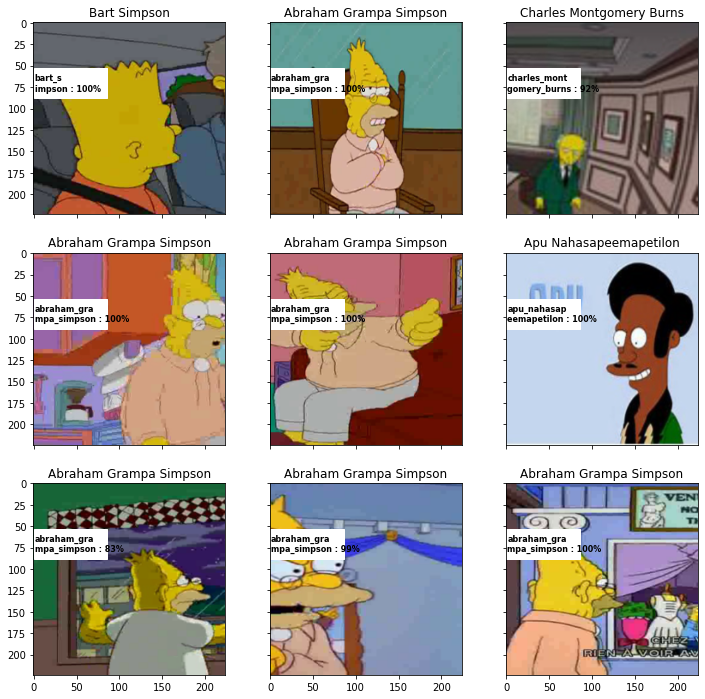

In [49]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(densenet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# **Submit на Kaggle**

In [51]:
import pandas as pd

test_dataset = SimpsonsDataset(test_files, mode="test")

test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
classes = [path.name for path in test_dataset.files]
predictions = label_encoder.inverse_transform(np.argmax(predict(densenet, test_loader), axis=1))

ans = pd.DataFrame(columns=['Id', 'Expected'])
ans['Id'] = classes
ans['Expected'] = predictions

#проверяем, что в файле с предсказаниями нужное количество строк
assert len(ans) == 991

#сохраняем предсказания модели для тестовой выборки, путь для kaggle, можно поменять на нужный
ans.to_csv('/kaggle/working/densenet_f.csv', index=False)